In [1]:
# Libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import deconomix as dcx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = sc.read_h5ad('../Data/DISCO/disco_breast_v01.h5ad', backed='r')

In [4]:
# Sample 100 cells per cell type without loading whole data into RAM

cell_types = data.obs['ct'].unique()
n_per_type = 100
sample_indices = []

# Avoid fancy indexing out of bounds errors by only sampling from valid indices in obs_names
obs_names = np.array(data.obs_names)  # All obs_names as numpy array

labels_per_index = []

for ct in cell_types:
    # Get obs_names for this cell type
    ct_mask = (data.obs['ct'] == ct)
    ct_names = obs_names[ct_mask.values]
    idx = np.where(ct_mask)[0]
    if len(idx) == 0:
        continue  # Skip empty cell types if any (should not happen)
    if len(idx) > n_per_type:
        sampled_idx = np.random.choice(idx, n_per_type, replace=False)
    else:
        sampled_idx = idx  # If less than 100, take all
    sample_indices.extend(sampled_idx.tolist())
    labels_per_index.extend([ct] * len(sampled_idx))

sample_indices = np.array(sample_indices)
labels_per_index = np.array(labels_per_index)
# Sort both indices and labels according to index order
sorted_indices = np.argsort(sample_indices)
sample_indices = sample_indices[sorted_indices]
labels_per_index = labels_per_index[sorted_indices]

# Subset the AnnData object to the sampled cells
data_subset = pd.DataFrame(data.X[sample_indices,:].toarray(),
                           index=labels_per_index,
                           columns=data.var['gene']).T
print(f"Sampled AnnData shape: {data_subset.shape}")

# Calculate an average expression profile per cell type (across cells with the same label)
mean_profiles = data_subset.groupby(axis=1, level=0).mean()
mean_profiles

Sampled AnnData shape: (33538, 3400)


,Arterial EC,B cell,Breast basal cell,Breast cancer specific luminal cell,Breast cancer specific proliferation luminal cell,CD4 T,CFD fibroblast,CXCL1/2/3 fibroblast,CXCL13 exhausted CD8 T,Capillary EC,...,Proliferation macrophage,Smooth muscle cell,TGM2 luminal cell,TNBC-specific epithelial cell,Tfh,Treg,Venous EC,cDC2,mregDC,pDC
gene,,,,,,,,,,,,,,,,,,,,,
MIR1302-2HG,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
FAM138A,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
OR4F5,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
AL627309.1,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.00
AL627309.3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.23
AC233755.1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
AC240274.1,0.0,0.01,0.02,0.06,0.02,0.01,0.01,0.02,0.01,0.02,...,0.03,0.0,0.04,0.0,0.0,0.0,0.01,0.03,0.0,0.00


In [5]:
# Calculate variance across the rows of mean_profiles (i.e., variance for each gene across cell types)
gene_variances = mean_profiles.var(axis=1)
gene_variances_sorted = gene_variances.sort_values(ascending=False)

top_genes_DISCO = pd.Series(gene_variances_sorted.index, name='gene')

In [6]:
# import tcga bulks and labels
# TCGA data downloaded by running tcga_downloader.py once, extract the downloaded archives, then run it again...
data_tcga = pd.read_csv("../Data/TCGA/tcga_brca_rnaseq_counts.csv", index_col=0)
pam50_row = data_tcga.loc["PAM50"].tolist()  # Extract PAM50 row as a list
data_tcga = data_tcga.drop("PAM50")  # Remove PAM50 row from main data
data_tcga = data_tcga.apply(pd.to_numeric, errors="coerce").astype("Int64")

/tmp/ipykernel_5110/479407470.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,2

In [7]:
data_tcga.shape


(59427, 1231)

In [8]:
data_tcga_sorted = data_tcga.loc[data_tcga.mean(axis=1).sort_values(ascending=False).index]


In [9]:
data_tcga_sorted

,TCGA-B6-A408,TCGA-AQ-A04L,TCGA-E2-A15S,TCGA-D8-A1JK,TCGA-B6-A0RT,TCGA-BH-A1F2,TCGA-LL-A441,TCGA-A2-A3XT,TCGA-BH-A0GY,TCGA-BH-A18S,...,TCGA-AN-A0AM,TCGA-BH-A1FJ.1,TCGA-E2-A156,TCGA-BH-A1FU.1,TCGA-E2-A109,TCGA-C8-A137,TCGA-A1-A0SE,TCGA-B6-A0IN,TCGA-A8-A06R,TCGA-AR-A1AT
gene_name,,,,,,,,,,,,,,,,,,,,,
MT-CO1,299791,521447,797389,279341,488170,1465887,527612,661690,525559,463940,...,606803,831517,135118,314524,320554,462639,527240,2964382,805821,199842
MT-ND4,311574,621749,753177,415267,425935,1840491,563087,783711,401412,382631,...,488301,557868,100725,297144,317598,479790,307248,2045678,620835,113704
MT-RNR2,277857,1115153,505713,339793,566646,862805,244761,293525,552527,299345,...,435462,472948,88642,208100,133102,280560,318817,2018312,614226,89138
COL1A1,468859,415819,74433,367057,157404,83071,304139,170682,234455,11509,...,426867,74637,19135,69468,498812,352846,735106,217399,476371,185022
MT-CO3,220218,432483,443624,215089,264981,814643,264888,317206,364432,277287,...,302122,487735,64094,163790,163648,313247,240299,1647742,454892,87316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC008446.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SNORA6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hsa-mir-423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
top_genes_DISCO_filtered = [gene for gene in top_genes_DISCO if gene in data_tcga.index]

In [11]:
top_genes_TCGA = data_tcga_sorted.index.values

In [12]:
top_genes_TCGA

array(['MT-CO1', 'MT-ND4', 'MT-RNR2', ..., 'hsa-mir-423', 'AC063949.2',
       'SNORA71C'], shape=(59427,), dtype=object)

In [13]:
# Ct label aggregation
ct_aggregation = pd.read_csv('../Data/DISCO/cell_type_aggregation.csv')
ct_major = dict(zip(ct_aggregation['Cell type (DISCO)'], ct_aggregation['Cell type (major)']))
ct_minor = dict(zip(ct_aggregation['Cell type (DISCO)'], ct_aggregation['Cell type (minor)']))

In [14]:
data_cancer = data[(data.obs['disease'] == 'breast cancer') & (data.obs['sample_type'] == 'solid tumor')]

In [15]:
gene_mask = data.var.index.isin(top_genes_DISCO_filtered)

In [16]:
disco_cancer = pd.DataFrame(data_cancer.X[:,gene_mask].toarray().T,
                        index=data_cancer.var['gene'][gene_mask].values,
                        columns=data_cancer.obs['ct'].map(ct_minor))

In [17]:
#Reorder index to match order of consensus genes
disco_cancer = disco_cancer.reindex(top_genes_DISCO_filtered)

In [18]:
#Normalize to 10k counts per sample
disco_cancer_norm = disco_cancer * (10000 / disco_cancer.sum())

In [19]:
# generate articicial Disco bulks and normalize them as well

_, Y_disco, _ = dcx.utils.simulate_data(disco_cancer_norm, n_mixtures=1000, n_cells_in_mix=100)

In [20]:
Y_disco_norm = Y_disco * (10000 / Y_disco.sum())

In [21]:
data_tcga_norm = data_tcga * (10000 / data_tcga.sum())

In [22]:
# Caluclate conversion factors between both bulks
# x * tcga = disco
# disco/tcga = x
conv_factors = Y_disco_norm.loc[top_genes_DISCO_filtered,:].mean(axis=1)/data_tcga_norm.loc[top_genes_DISCO_filtered,:].mean(axis=1)

In [23]:
conv_factors

IGKC          5.023552
IGLC3         14.86153
IGHA1          0.60615
IGHM          1.251336
IGHG1         0.679134
                ...   
AC012442.1    0.419429
IL37          0.411112
IL36A         0.108516
IL36B         0.862835
C11orf16       0.24741
Length: 32087, dtype: Float64

In [24]:
conv_factors_filtered = conv_factors.dropna()
conv_factors_filtered = conv_factors_filtered[conv_factors_filtered < np.inf]
conv_factors_filtered = conv_factors_filtered[conv_factors_filtered >= 0.1]
conv_factors_filtered = conv_factors_filtered[conv_factors_filtered <= 10]


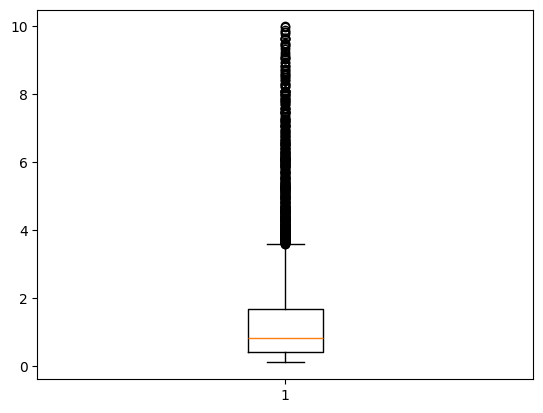

In [26]:
plt.boxplot(conv_factors_filtered[0:5000].values);

In [27]:
final_genes_and_conv = conv_factors_filtered[0:5000].reset_index()
final_genes_and_conv.columns = ['gene', 'conversion factor']

In [28]:
final_genes_and_conv

,gene,conversion factor
0,IGKC,5.023552
1,IGHA1,0.60615
2,IGHM,1.251336
3,IGHG1,0.679134
4,JCHAIN,1.337956
...,...,...
4995,PPID,0.951882
4996,STAMBP,0.670594
4997,EP300,0.200941
4998,PTGS1,0.265584


In [ ]:
final_genes_and_conv.to_csv('../Data/Preprocessed/final_genes_and_conv.csv', index=False)